# Understanding Chat Data 



Objective: Make sense of textual data by discovering volume and topic trends. 

Pre-requisites: 
Anaconda  https://docs.anaconda.com/anaconda/install/mac-os/  + Telegram Chat Data (Personal or Group)



Creator: Jia Min Leong (IG: @personalprojects.py)

In [79]:
import requests
import codecs
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
import re

# Parse Telegram HTML

Using BeautifulSoup package to transform HTML data (formatted for web interface) into a tabular format. 

In [34]:
from_sender_list = []
text_message_list = []
date_time_list = []

def message_details(message, from_sender_list, text_message_list, date_time_list):
    if message.find('div', {'class': 'text'}) is None:
        text_message_list.append('')
    else:
        text_message_list.append(message.find('div', {'class': 'text'}).get_text().rstrip().lstrip())
    
    if message.find('div', {'class': 'pull_right date details'}) is None:
        date_time_list.append('')
    else:
        date_time_list.append(message.find('div', {'class': 'pull_right date details'})['title'])
    
    
    if message.find('div', {'class': 'from_name'}) is None:
        from_sender_list.append(from_sender_list[-1])
    else:
        from_sender_list.append(message.find('div', {'class': 'from_name'}).get_text().rstrip().lstrip())

In [35]:
for i,item in enumerate(range(2,405)): #adjust this range based on how many html files you have
    f = codecs.open("messages{}.html".format(item),'r')
    parsed_html = BeautifulSoup(f, 'lxml')
    message_content = parsed_html.find_all('div',{'class':'body'})
    
    for message in message_content[1:]:
        message_details(message, from_sender_list, text_message_list, date_time_list)

In [36]:
df = pd.DataFrame({'from_sender':from_sender_list, 'text_message':text_message_list,'date_time':date_time_list})
df.head()

In [39]:
df = df.fillna('12.12.2222 10:10:10')
df['date_time'] = df.date_time.astype('str')

# Surface Trends - Volume

Using datetime package to parse timestamps into hour, month, quarter, year dimensions for easy visualisation

In [ ]:
def convert_month_to_quarter(date):
    if datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month >= 1 and datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month < 4:
        quarter = 'Q1'
    if datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month >= 4 and datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month < 7:
        quarter = 'Q2'
    if datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month >= 7 and datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month < 10:
        quarter = 'Q3'
    if datetime.strptime(date, '%d.%m.%Y %H:%M:%S').month >= 10:
        quarter = 'Q4'
    return quarter

In [40]:
df['date'] = [datetime.strptime(i, '%d.%m.%Y %H:%M:%S').date() for i in df.date_time]
df['hour'] = [datetime.strptime(i, '%d.%m.%Y %H:%M:%S').hour for i in df.date_time]
df['month'] = [datetime.strptime(i, '%d.%m.%Y %H:%M:%S').date().replace(day=1) for i in df.date_time]
df['year'] = [datetime.strptime(i, '%d.%m.%Y %H:%M:%S').date().year for i in df.date_time]
df['quarter'] = df.date_time.apply(lambda x: convert_month_to_quarter(x))

In [42]:
max(df.date) #2015, 1, 22

datetime.date(2222, 12, 12)

In [47]:
datecount = df.date.value_counts().reset_index().rename(columns ={'index':'month', 'month':'value_counts'}).sort_values(by='month')
datecount.tail()

In [48]:
monthcount = df.month.value_counts().reset_index().rename(columns ={'index':'month', 'month':'value_counts'}).sort_values(by='month')
monthcount = monthcount[monthcount['month'] <= datetime.strptime('2020-12-01','%Y-%m-%d').date()]
monthcount.tail()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

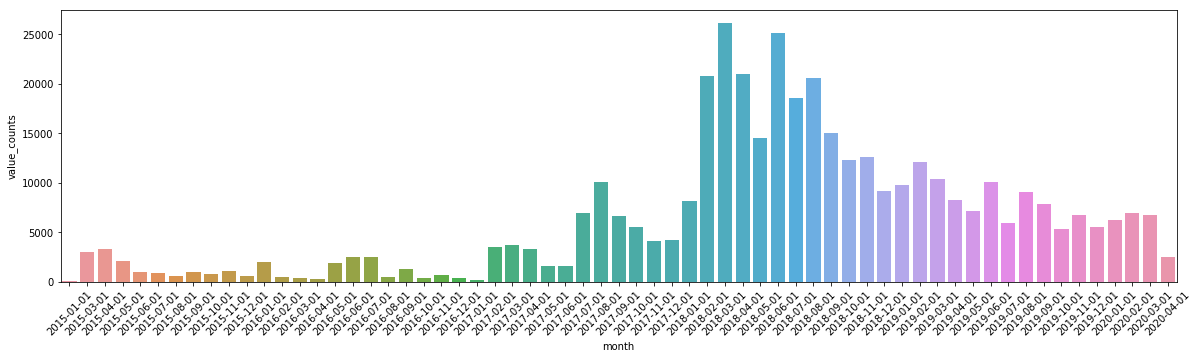

In [49]:
plt.figure(figsize=(20,5))
seaborn.barplot(monthcount.month, monthcount.value_counts)
plt.xticks(rotation=45) 

In [118]:
hourcount = df.groupby(['year','date','hour']).count()[['text_message']].reset_index()
hourcount_rebased = hourcount.groupby(['year','hour']).mean()[['text_message']].reset_index()
hourcount_rebased.text_message = hourcount_rebased.text_message.astype(int)
hourcount_rebased.head()

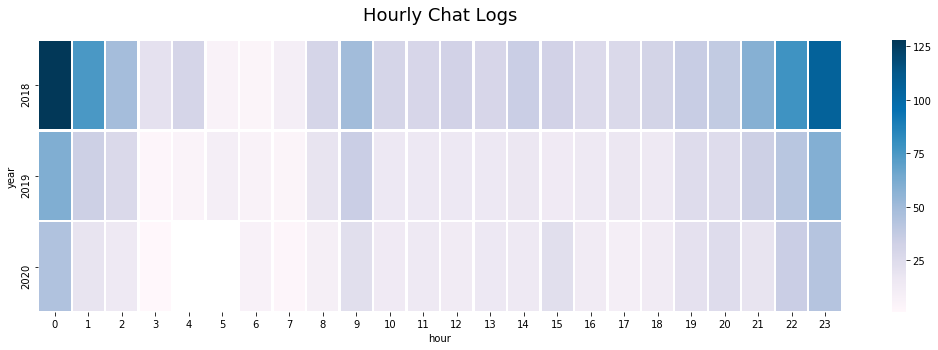

In [147]:
hourcount_rebased = hourcount_rebased[(hourcount_rebased['year']>= 2018) & (hourcount_rebased['year']<= 2020)]
result = pd.pivot_table(hourcount_rebased, values= 'text_message', index=['year'], columns=['hour'])
result.fillna(5)

fig, ax = plt.subplots(figsize=(18,5))
title = "Hourly Chat Logs"

plt.title(title, fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

ax.set_xticks([])
ax.set_yticks([])

sns.heatmap(result, cmap='PuBu', fmt='', linewidths=1.30, ax=ax)


# Surface Trends - Topics

Using regular expressions to match keywords (self-defined) and aggregate at meaningful cadences

In [ ]:
#creating a test DF to transform
testdf = df[(df['date'] <= datetime.strptime('2020-12-01','%Y-%m-%d').date()) & (df['date'] >= datetime.strptime('2018-06-01','%Y-%m-%d').date())]
testdf['year_quarter'] = testdf['year'].astype('str') + testdf['quarter']

In [16]:
def derive_occurrences(string,granularity):
    testdf['infocus'] = testdf.text_message.str.contains(string, regex=True, case=False)
    infocusdf = testdf[testdf['infocus']==True]
    consolidatingdf = infocusdf[granularity].value_counts().reset_index().rename(columns ={'index':granularity, granularity:'value_counts'}).sort_values(by=granularity)
    consolidatingdf['infocus'] = string
    minidf = pd.pivot_table(consolidatingdf, values='value_counts',index=['infocus'], columns=[granularity], aggfunc=np.sum, fill_value=0).reset_index()
    return minidf

In [1]:
stringlist = ['dinner', 'dating|date','watch|show', 'netflix', 
              'picnic|movie', 'friday', 'dessert|cream|cake|chocolate|prata']

len(stringlist)

7

In [67]:
megadf = pd.DataFrame()

for string in stringlist:
    minidf = derive_occurrences(string, 'month')
    megadf = megadf.append(minidf)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
megadf.fillna(0)
#saving the results
megadf.to_csv('trendsdiscovery.csv')